In [99]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from functions import *
from functions import plotting

(2115, 22, 1000)
(2115, 22, 1000)
(2115, 1000)


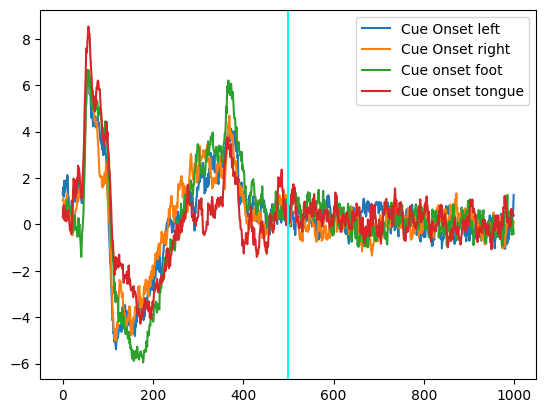

In [100]:
## Loading and visualizing the data

## Loading the dataset
X_test = np.load("../ECEC147project-data/X_test.npy")
y_test = np.load("../ECEC147project-data//y_test.npy")
person_train_valid = np.load("../ECEC147project-data//person_train_valid.npy")
X_train_valid = np.load("../ECEC147project-data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("../ECEC147project-data/y_train_valid.npy")
person_test = np.load("../ECEC147project-data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data
print(X_train_valid.shape)
ch_data = X_train_valid[:,8,:]
print(ch_data.shape)
class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [101]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    # print('Shape of Y:',total_y.shape)
    return total_X,total_y



def test_data_prep(X):
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 1), axis=3)
    
    
    total_X = X_max
    # print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [102]:
def hybrid(size):
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(size,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 4
    hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    return hybrid_cnn_lstm_model

In [103]:
X_test_prep = test_data_prep(X_test) 
print(np.shape(X_test_prep))
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train_split, x_valid_split) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_split, y_valid_split) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_train,y_train = train_data_prep(x_train_split,y_train_split,1,1,True)
X_valid_prep= test_data_prep(x_valid_split)
print(np.shape(X_valid_prep))
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)
print(np.shape(y_test))
y_valid = to_categorical(y_valid_split, 4)
print(np.shape(y_valid))
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_valid = X_valid_prep.reshape(X_valid_prep.shape[0], X_valid_prep.shape[1], X_valid_prep.shape[2], 1)
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)

x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

(443, 22, 1000)
(250, 22, 1000)
(443, 4)
(250, 4)


In [104]:
# Model parameters
learning_rate = 1e-3
epochs = 150

100
Epoch 1/150
88/88 [==============================] - 5s 30ms/step - loss: 1.3849 - accuracy: 0.2829 - val_loss: 1.3977 - val_accuracy: 0.2600
Epoch 2/150
88/88 [==============================] - 2s 28ms/step - loss: 1.3716 - accuracy: 0.3087 - val_loss: 1.4002 - val_accuracy: 0.3040
Epoch 3/150
88/88 [==============================] - 2s 26ms/step - loss: 1.3625 - accuracy: 0.3187 - val_loss: 1.3778 - val_accuracy: 0.3360
Epoch 4/150
88/88 [==============================] - 2s 28ms/step - loss: 1.3457 - accuracy: 0.3378 - val_loss: 1.3854 - val_accuracy: 0.3640
Epoch 5/150
88/88 [==============================] - 2s 26ms/step - loss: 1.3395 - accuracy: 0.3437 - val_loss: 1.3688 - val_accuracy: 0.3520
Epoch 6/150
88/88 [==============================] - 2s 26ms/step - loss: 1.3189 - accuracy: 0.3603 - val_loss: 1.3329 - val_accuracy: 0.4080
Epoch 7/150
88/88 [==============================] - 3s 29ms/step - loss: 1.3055 - accuracy: 0.3732 - val_loss: 1.3249 - val_accuracy: 0.3960
Ep

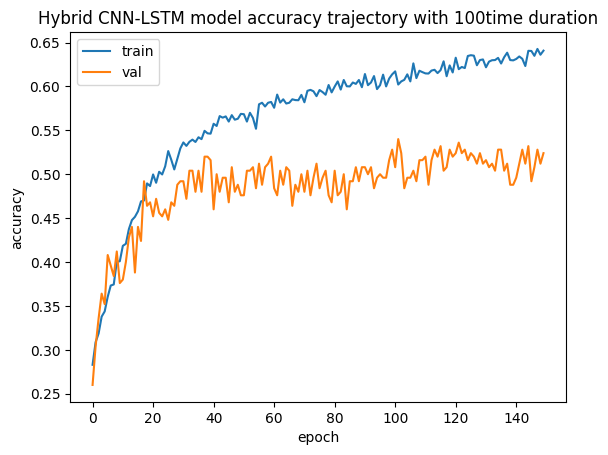

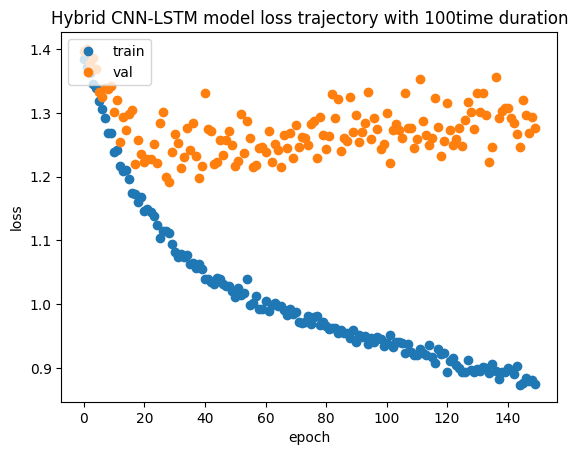

Test accuracy of the hybrid CNN-LSTM model: 0.544018030166626
200
Epoch 1/150
88/88 [==============================] - 5s 40ms/step - loss: 1.3864 - accuracy: 0.2752 - val_loss: 1.3731 - val_accuracy: 0.3400
Epoch 2/150
88/88 [==============================] - 3s 35ms/step - loss: 1.3622 - accuracy: 0.3181 - val_loss: 1.3403 - val_accuracy: 0.3760
Epoch 3/150
88/88 [==============================] - 3s 35ms/step - loss: 1.3292 - accuracy: 0.3567 - val_loss: 1.3504 - val_accuracy: 0.3800
Epoch 4/150
88/88 [==============================] - 3s 36ms/step - loss: 1.3041 - accuracy: 0.3866 - val_loss: 1.3693 - val_accuracy: 0.3440
Epoch 5/150
88/88 [==============================] - 3s 36ms/step - loss: 1.2855 - accuracy: 0.3977 - val_loss: 1.3213 - val_accuracy: 0.4080
Epoch 6/150
88/88 [==============================] - 3s 37ms/step - loss: 1.2546 - accuracy: 0.4182 - val_loss: 1.3407 - val_accuracy: 0.3760
Epoch 7/150
88/88 [==============================] - 3s 35ms/step - loss: 1.2357 -

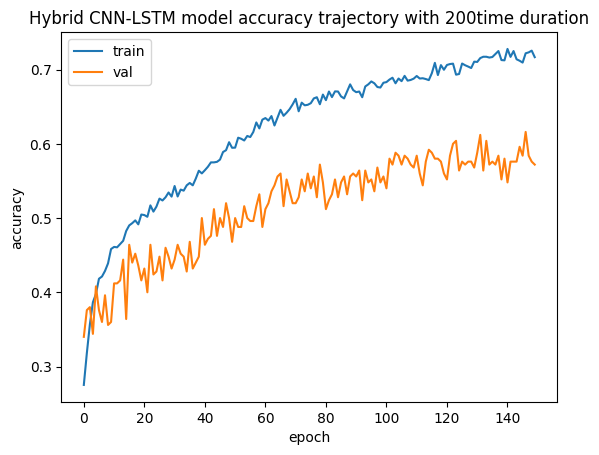

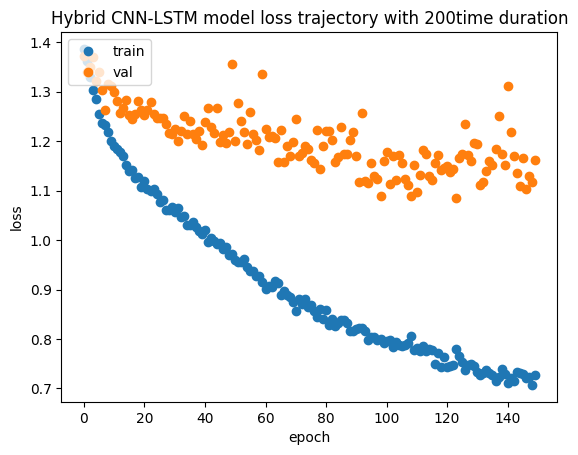

Test accuracy of the hybrid CNN-LSTM model: 0.6433408856391907
300
Epoch 1/150
88/88 [==============================] - 6s 50ms/step - loss: 1.3801 - accuracy: 0.2776 - val_loss: 1.3800 - val_accuracy: 0.2640
Epoch 2/150
88/88 [==============================] - 4s 47ms/step - loss: 1.3538 - accuracy: 0.3214 - val_loss: 1.3304 - val_accuracy: 0.3240
Epoch 3/150
88/88 [==============================] - 4s 46ms/step - loss: 1.3044 - accuracy: 0.3836 - val_loss: 1.3886 - val_accuracy: 0.3400
Epoch 4/150
88/88 [==============================] - 4s 46ms/step - loss: 1.2622 - accuracy: 0.4136 - val_loss: 1.3814 - val_accuracy: 0.3440
Epoch 5/150
88/88 [==============================] - 4s 48ms/step - loss: 1.2306 - accuracy: 0.4352 - val_loss: 1.3940 - val_accuracy: 0.3680
Epoch 6/150
88/88 [==============================] - 4s 44ms/step - loss: 1.2054 - accuracy: 0.4475 - val_loss: 1.3010 - val_accuracy: 0.4200
Epoch 7/150
88/88 [==============================] - 4s 46ms/step - loss: 1.1802 

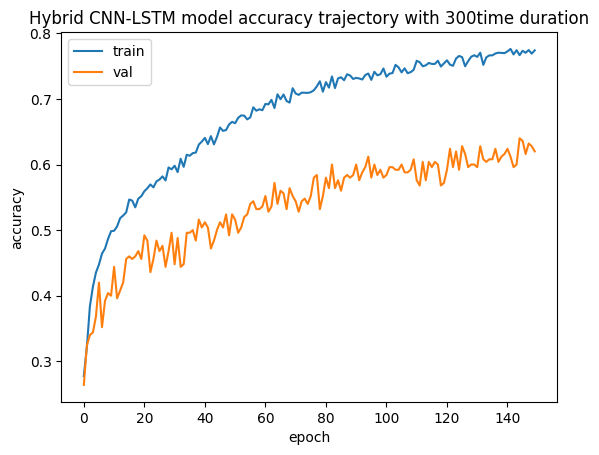

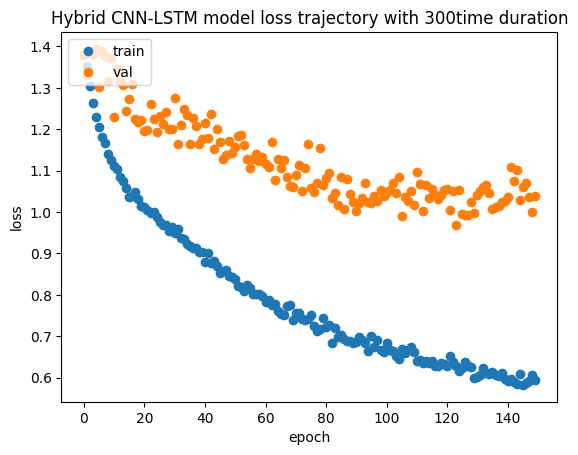

Test accuracy of the hybrid CNN-LSTM model: 0.6839728951454163
400
Epoch 1/150
88/88 [==============================] - 7s 59ms/step - loss: 1.3741 - accuracy: 0.2929 - val_loss: 1.3403 - val_accuracy: 0.3840
Epoch 2/150
88/88 [==============================] - 5s 57ms/step - loss: 1.3319 - accuracy: 0.3373 - val_loss: 1.3341 - val_accuracy: 0.3880
Epoch 3/150
88/88 [==============================] - 5s 55ms/step - loss: 1.2845 - accuracy: 0.3712 - val_loss: 1.2973 - val_accuracy: 0.3880
Epoch 4/150
88/88 [==============================] - 5s 55ms/step - loss: 1.2611 - accuracy: 0.4063 - val_loss: 1.3440 - val_accuracy: 0.3400
Epoch 5/150
88/88 [==============================] - 5s 57ms/step - loss: 1.2367 - accuracy: 0.4216 - val_loss: 1.2801 - val_accuracy: 0.4120
Epoch 6/150
88/88 [==============================] - 5s 56ms/step - loss: 1.2064 - accuracy: 0.4434 - val_loss: 1.2997 - val_accuracy: 0.4360
Epoch 7/150
88/88 [==============================] - 5s 55ms/step - loss: 1.1733 

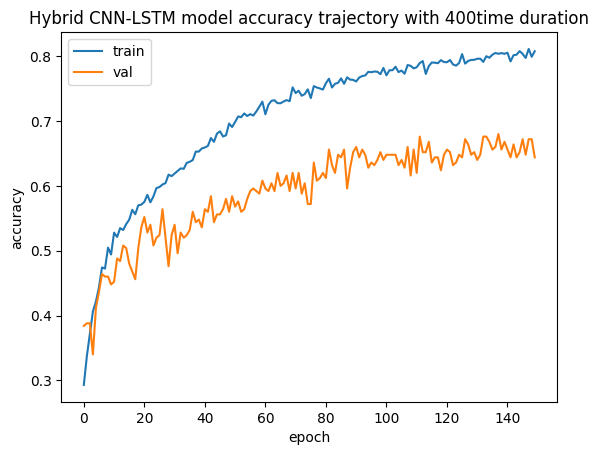

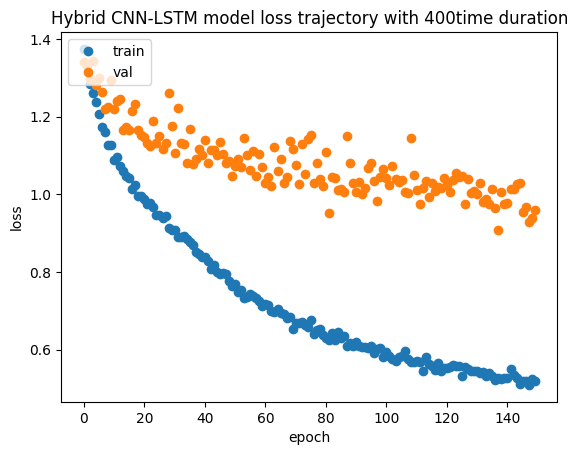

Test accuracy of the hybrid CNN-LSTM model: 0.6884875893592834
500
Epoch 1/150
88/88 [==============================] - 7s 66ms/step - loss: 1.3892 - accuracy: 0.2829 - val_loss: 1.3678 - val_accuracy: 0.3120
Epoch 2/150
88/88 [==============================] - 6s 64ms/step - loss: 1.3447 - accuracy: 0.3567 - val_loss: 1.3856 - val_accuracy: 0.2760
Epoch 3/150
88/88 [==============================] - 5s 61ms/step - loss: 1.3042 - accuracy: 0.3970 - val_loss: 1.3873 - val_accuracy: 0.3080
Epoch 4/150
88/88 [==============================] - 6s 63ms/step - loss: 1.2644 - accuracy: 0.4225 - val_loss: 1.3785 - val_accuracy: 0.2800
Epoch 5/150
88/88 [==============================] - 6s 65ms/step - loss: 1.2215 - accuracy: 0.4499 - val_loss: 1.3162 - val_accuracy: 0.3760
Epoch 6/150
88/88 [==============================] - 6s 63ms/step - loss: 1.1910 - accuracy: 0.4613 - val_loss: 1.2937 - val_accuracy: 0.3840
Epoch 7/150
88/88 [==============================] - 6s 63ms/step - loss: 1.1893 

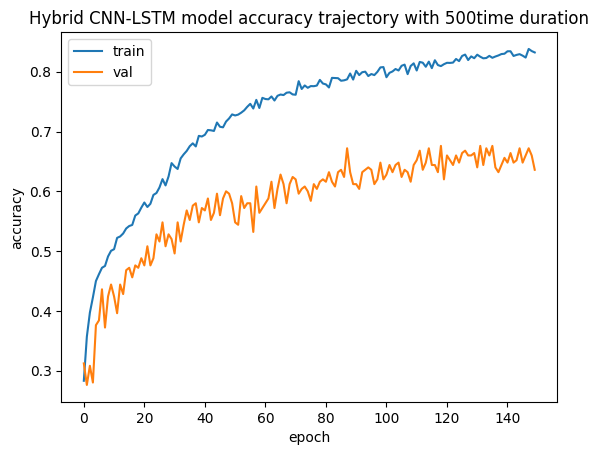

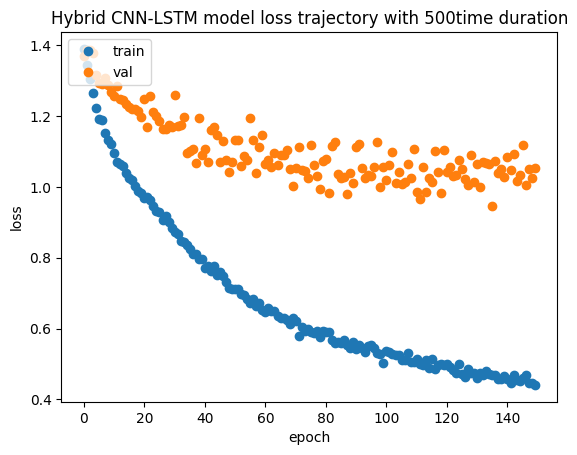

Test accuracy of the hybrid CNN-LSTM model: 0.7042889595031738
600
Epoch 1/150
88/88 [==============================] - 8s 74ms/step - loss: 1.3722 - accuracy: 0.2931 - val_loss: 1.3456 - val_accuracy: 0.3640
Epoch 2/150
88/88 [==============================] - 6s 74ms/step - loss: 1.3087 - accuracy: 0.3598 - val_loss: 1.2961 - val_accuracy: 0.4160
Epoch 3/150
88/88 [==============================] - 7s 76ms/step - loss: 1.2713 - accuracy: 0.3962 - val_loss: 1.2844 - val_accuracy: 0.3920
Epoch 4/150
88/88 [==============================] - 7s 75ms/step - loss: 1.2368 - accuracy: 0.4275 - val_loss: 1.2502 - val_accuracy: 0.4560
Epoch 5/150
88/88 [==============================] - 6s 72ms/step - loss: 1.2018 - accuracy: 0.4552 - val_loss: 1.2651 - val_accuracy: 0.4560
Epoch 6/150
88/88 [==============================] - 7s 75ms/step - loss: 1.1683 - accuracy: 0.4767 - val_loss: 1.2324 - val_accuracy: 0.4720
Epoch 7/150
88/88 [==============================] - 6s 73ms/step - loss: 1.1500 

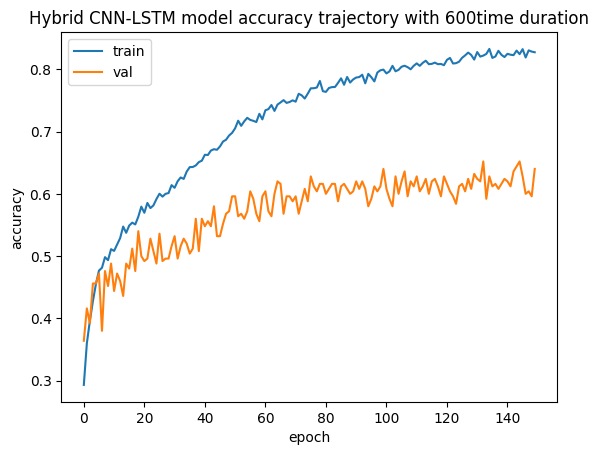

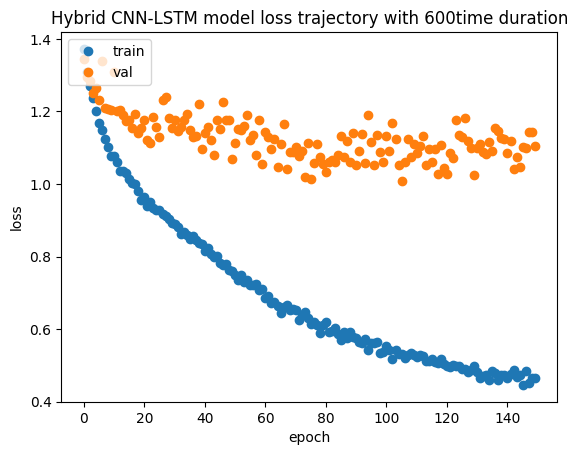

Test accuracy of the hybrid CNN-LSTM model: 0.690744936466217
700
Epoch 1/150
88/88 [==============================] - 9s 85ms/step - loss: 1.3849 - accuracy: 0.2799 - val_loss: 1.3749 - val_accuracy: 0.3040
Epoch 2/150
88/88 [==============================] - 7s 81ms/step - loss: 1.3384 - accuracy: 0.3537 - val_loss: 1.3313 - val_accuracy: 0.3560
Epoch 3/150
88/88 [==============================] - 7s 81ms/step - loss: 1.2727 - accuracy: 0.4181 - val_loss: 1.2775 - val_accuracy: 0.3960
Epoch 4/150
88/88 [==============================] - 7s 80ms/step - loss: 1.2323 - accuracy: 0.4399 - val_loss: 1.2677 - val_accuracy: 0.4200
Epoch 5/150
88/88 [==============================] - 7s 82ms/step - loss: 1.1941 - accuracy: 0.4545 - val_loss: 1.2666 - val_accuracy: 0.4320
Epoch 6/150
88/88 [==============================] - 7s 82ms/step - loss: 1.1760 - accuracy: 0.4554 - val_loss: 1.2545 - val_accuracy: 0.4200
Epoch 7/150
88/88 [==============================] - 7s 79ms/step - loss: 1.1482 -

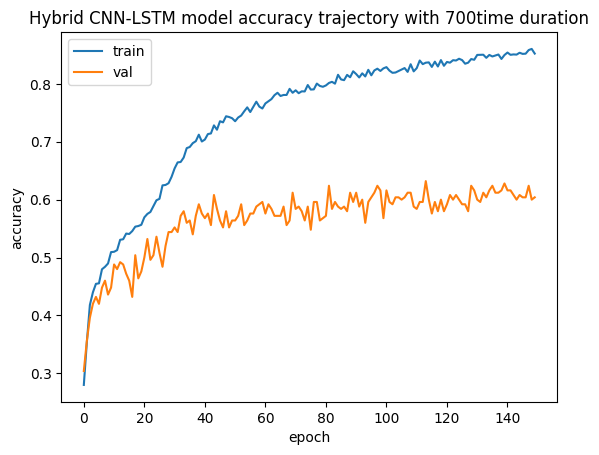

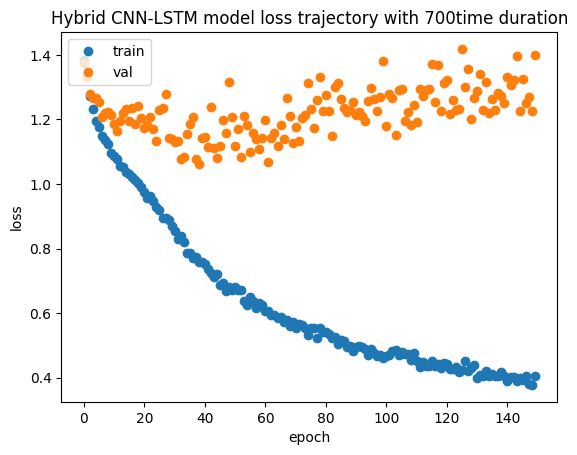

Test accuracy of the hybrid CNN-LSTM model: 0.6275395154953003
800
Epoch 1/150
88/88 [==============================] - 9s 89ms/step - loss: 1.3834 - accuracy: 0.2736 - val_loss: 1.3870 - val_accuracy: 0.2160
Epoch 2/150
88/88 [==============================] - 8s 89ms/step - loss: 1.3453 - accuracy: 0.3373 - val_loss: 1.3033 - val_accuracy: 0.3800
Epoch 3/150
88/88 [==============================] - 8s 87ms/step - loss: 1.2853 - accuracy: 0.3968 - val_loss: 1.2785 - val_accuracy: 0.3800
Epoch 4/150
88/88 [==============================] - 8s 87ms/step - loss: 1.2379 - accuracy: 0.4257 - val_loss: 1.2533 - val_accuracy: 0.4160
Epoch 5/150
88/88 [==============================] - 8s 88ms/step - loss: 1.2088 - accuracy: 0.4488 - val_loss: 1.2696 - val_accuracy: 0.4240
Epoch 6/150
88/88 [==============================] - 8s 87ms/step - loss: 1.1773 - accuracy: 0.4690 - val_loss: 1.3686 - val_accuracy: 0.3560
Epoch 7/150
88/88 [==============================] - 8s 90ms/step - loss: 1.1517 

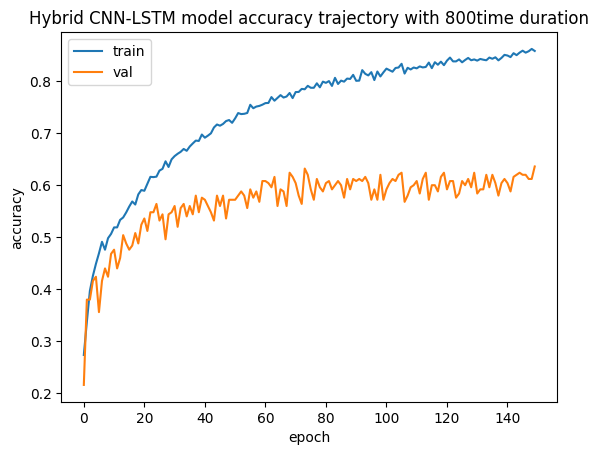

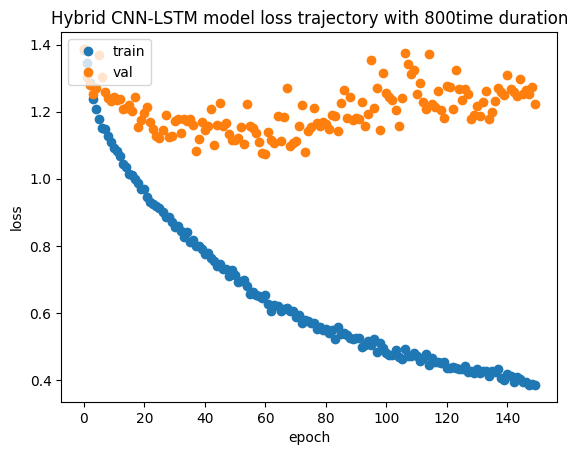

Test accuracy of the hybrid CNN-LSTM model: 0.6749435663223267
900
Epoch 1/150
88/88 [==============================] - 10s 93ms/step - loss: 1.3719 - accuracy: 0.2983 - val_loss: 1.3422 - val_accuracy: 0.3280
Epoch 2/150
88/88 [==============================] - 8s 91ms/step - loss: 1.3053 - accuracy: 0.3685 - val_loss: 1.3381 - val_accuracy: 0.3520
Epoch 3/150
88/88 [==============================] - 8s 91ms/step - loss: 1.2592 - accuracy: 0.4073 - val_loss: 1.3492 - val_accuracy: 0.3720
Epoch 4/150
88/88 [==============================] - 8s 92ms/step - loss: 1.2367 - accuracy: 0.4238 - val_loss: 1.2929 - val_accuracy: 0.3920
Epoch 5/150
88/88 [==============================] - 8s 91ms/step - loss: 1.2104 - accuracy: 0.4565 - val_loss: 1.2740 - val_accuracy: 0.4560
Epoch 6/150
88/88 [==============================] - 8s 91ms/step - loss: 1.1866 - accuracy: 0.4683 - val_loss: 1.3212 - val_accuracy: 0.4200
Epoch 7/150
88/88 [==============================] - 8s 91ms/step - loss: 1.1669

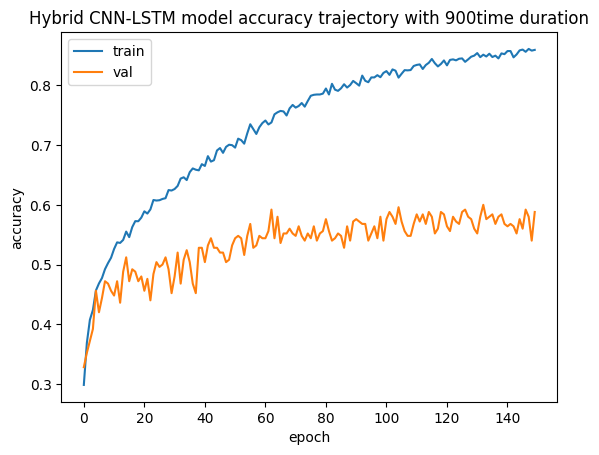

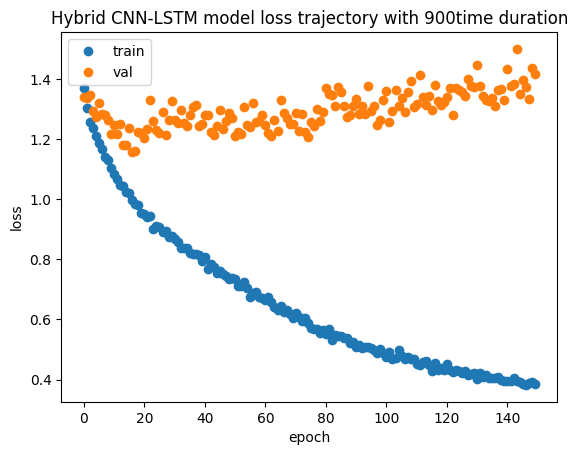

Test accuracy of the hybrid CNN-LSTM model: 0.5846500992774963
1000
Epoch 1/150
88/88 [==============================] - 10s 98ms/step - loss: 1.3806 - accuracy: 0.2788 - val_loss: 1.3665 - val_accuracy: 0.3160
Epoch 2/150
88/88 [==============================] - 8s 95ms/step - loss: 1.3491 - accuracy: 0.3430 - val_loss: 1.3514 - val_accuracy: 0.3280
Epoch 3/150
88/88 [==============================] - 9s 97ms/step - loss: 1.3008 - accuracy: 0.3946 - val_loss: 1.3414 - val_accuracy: 0.3760
Epoch 4/150
88/88 [==============================] - 9s 97ms/step - loss: 1.2503 - accuracy: 0.4311 - val_loss: 1.2583 - val_accuracy: 0.4560
Epoch 5/150
88/88 [==============================] - 8s 96ms/step - loss: 1.2125 - accuracy: 0.4452 - val_loss: 1.3676 - val_accuracy: 0.3760
Epoch 6/150
88/88 [==============================] - 9s 98ms/step - loss: 1.1793 - accuracy: 0.4647 - val_loss: 1.3571 - val_accuracy: 0.3640
Epoch 7/150
88/88 [==============================] - 9s 98ms/step - loss: 1.153

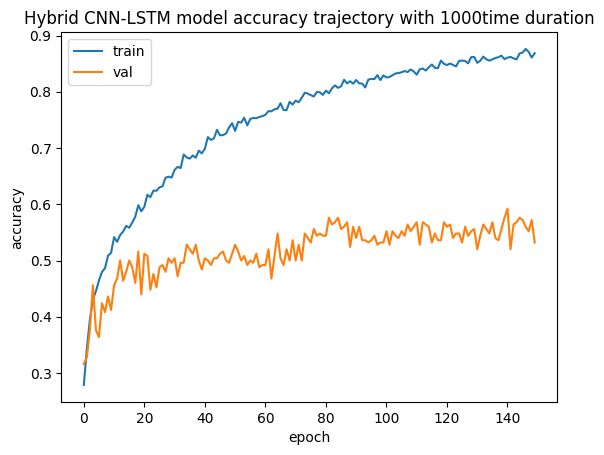

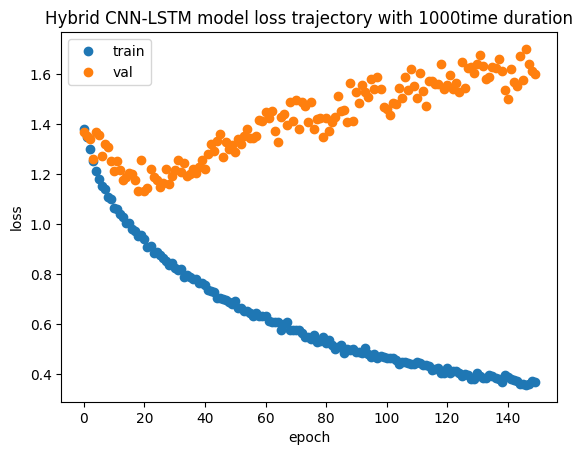

Test accuracy of the hybrid CNN-LSTM model: 0.6252821683883667


In [105]:
accuracy = []

for i in range(100, 1001, 100):
    print(i)
    x_train_trim = x_train[:, :i, :, :]
    x_valid_trim = x_valid[:, :i, :, :]
    x_test_trim = x_test[:, :i, :, :]

    hybrid_cnn_lstm_model = hybrid(i)
    # ADAM
    # Compiling the model
    hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train_trim,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_trim, y_valid), verbose=True)

    # Plotting accuracy trajectory
    plt.plot( hybrid_cnn_lstm_model_results.history['accuracy'])
    plt.plot( hybrid_cnn_lstm_model_results.history['val_accuracy'])
    plt.title('Hybrid CNN-LSTM model accuracy trajectory with ' + str(i) + 'time duration')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plotting loss trajectory
    plt.plot( hybrid_cnn_lstm_model_results.history['loss'],'o')
    plt.plot( hybrid_cnn_lstm_model_results.history['val_loss'],'o')
    plt.title('Hybrid CNN-LSTM model loss trajectory with ' + str(i) + 'time duration')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_trim, y_test, verbose=0)
    print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])
    accuracy.append(hybrid_cnn_lstm_score[1])
    

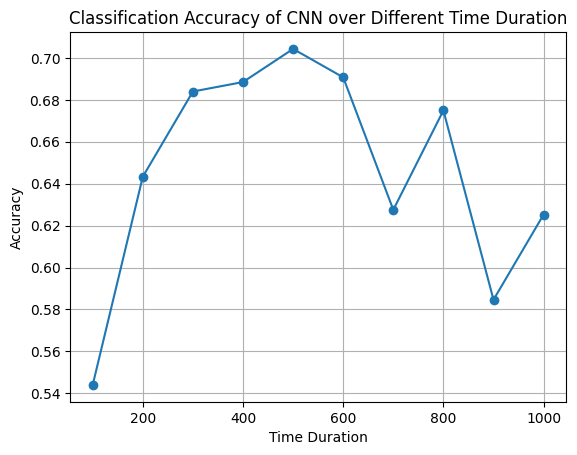

In [106]:
time_duration = list(range(100, 1001, 100))

# Plotting
plt.plot(time_duration, accuracy, marker='o')
plt.title('Classification Accuracy of CNN over Different Time Duration')
plt.xlabel('Time Duration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
